In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import numpy as np

import os

/home/ben/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def parse_trends_timestamp(timestamp):
    datetime_str = timestamp.split(' ')
    return datetime.datetime.fromisoformat(datetime_str[0].split('/')[2]+'-'+datetime_str[0].split('/')[0]+'-'+datetime_str[0].split('/')[1]+ ' ' + datetime_str[1])

In [3]:
def parse_feedback_timestamp(timestamp):
    date_str = timestamp.split('T')[0]
    time_str = timestamp.split('T')[1]

    return datetime.datetime.fromisoformat(date_str + ' ' + time_str[:5])

### Loading Feedback data


In [4]:
feedback_room_df = pd.read_csv('../data/abschluss-daten/feedback_room.csv')
device_df = pd.read_csv('../data/abschluss-daten/device.csv')
participant_df = pd.read_csv('../data/abschluss-daten/participant.csv')

In [5]:

for column_name in device_df.columns:
    if 'timestamp' in column_name or 'At' in column_name:
        device_df[column_name] = device_df[column_name].dropna().apply(parse_feedback_timestamp)

for column_name in participant_df.columns:
    if 'timestamp' in column_name or 'At' in column_name:
        participant_df[column_name] = participant_df[column_name].dropna().apply(parse_feedback_timestamp)

for column_name in feedback_room_df.columns:
    if 'timestamp' in column_name or 'At' in column_name:
        feedback_room_df[column_name] = feedback_room_df[column_name].dropna().apply(datetime.datetime.fromisoformat)


### Loading Temperature & Air quality data

Loading data is done as a batch, a dataframe variable is created for each file with its name in the form rx_xx_df according to the file read.

In [6]:
dir_list = os.listdir('../data/Trends Smart City/0EG') + os.listdir('../data/Trends Smart City/1OG') + os.listdir('../data/Trends Smart City/2OG') + os.listdir('../data/Trends Smart City/3OG')

In [7]:
df_names = []

for filename in dir_list:
    split_name = filename.lower().split(' ')
    further_split_name = split_name[0].split('-')
    df_name = further_split_name[1]+'_'+further_split_name[2]

    if 'Lufttemp' in filename:
        df_name += '_temp_df'

    else:
        df_name += '_qual_df'

    #df_name = '_'.join(further_split_name[1:])+'_df'
    df_names.append(df_name)

   

    if further_split_name[1] == 'r0':
        globals()[df_name] = pd.read_csv('../data/Trends Smart City/0EG/'+filename,sep=';',header=0,usecols = [i for i in range(3)],names=['timestamp','value','reduced'])

    elif further_split_name[1] == 'r1':
        globals()[df_name] = pd.read_csv('../data/Trends Smart City/1OG/'+filename,sep=';',header=0,usecols = [i for i in range(3)],names=['timestamp','value','reduced'])

    elif further_split_name[1] == 'r2':
        globals()[df_name] = pd.read_csv('../data/Trends Smart City/2OG/'+filename,sep=';',header=0,usecols = [i for i in range(3)],names=['timestamp','value','reduced'])

    elif further_split_name[1] == 'r3':
        globals()[df_name] = pd.read_csv('../data/Trends Smart City/3OG/'+filename,sep=';',header=0,usecols = [i for i in range(3)],names=['timestamp','value','reduced'])

    globals()[df_name]['timestamp'] = globals()[df_name]['timestamp'].apply(parse_trends_timestamp)

Changing the room name format to match that used in the trends dataset

In [8]:
def parse_roomName(roomName):
    if 'VS' not in roomName:
        return

    roomName = roomName[3:]
    roomName = roomName.split('.')
    return 'r'+'_'.join(roomName)



In [9]:
feedback_room_df['roomName'] = feedback_room_df['roomName'].apply(parse_roomName)

### Splitting feedback data

In [10]:
daily_airDraft_df = feedback_room_df[['daily_airDraft_timestamp','daily_airDraft_value','roomName']].dropna()
daily_ambientSounds_df = feedback_room_df[['daily_ambientSounds_timestamp','daily_ambientSounds_value','roomName']].dropna()
daily_artificialLight_df = feedback_room_df[['daily_artificialLight_timestamp','daily_artificialLight_value','roomName']].dropna()
daily_dayLight_df = feedback_room_df[['daily_dayLight_timestamp','daily_dayLight_value','roomName']].dropna()
daily_smell_df = feedback_room_df[['daily_smell_timestamp','daily_smell_value','roomName']].dropna()
daily_studentsAdherence_df = feedback_room_df[['daily_studentsAdherence_timestamp', 'daily_studentsAdherence_value','roomName']].dropna()
daily_studentsFocused_df = feedback_room_df[['daily_studentsFocused_timestamp', 'daily_studentsFocused_value','roomName']].dropna()
daily_studentsIrritated_df = feedback_room_df[['daily_studentsIrritated_timestamp', 'daily_studentsIrritated_value','roomName']].dropna()
daily_studentsMotivated_df =feedback_room_df[['daily_studentsMotivated_timestamp', 'daily_studentsMotivated_value','roomName']].dropna()

hourly_airQuality_df = feedback_room_df[['hourly_airQuality_timestamp', 'hourly_airQuality_value','roomName']].dropna()
hourly_humidity_df = feedback_room_df[['hourly_humidity_timestamp', 'hourly_humidity_value','roomName']].dropna()
hourly_indoorClimate_df = feedback_room_df[['hourly_indoorClimate_timestamp', 'hourly_indoorClimate_value','roomName']].dropna()
hourly_temperature_df = feedback_room_df[['hourly_temperature_timestamp', 'hourly_temperature_value','roomName']].dropna()

## Plotting
Plotting scatterplots for values from feedback dataset agains the max temp/qual reading from the room air data

In [11]:
def get_max_in_past_hour(time,room,type='temp'):
  """
  Arguments: time and room from the feedback dataset,
      type: "temp" or "qual"
  """
  #skip rooms for which we don't have files for
  if room+'_'+type+'_df' not in df_names:
    #print('No data for room')
    return np.nan

  #Loading room air data
  room_data = globals()[room+'_'+type+'_df'].sort_values(by='timestamp')

  #locating values from 1 hour before 
  mask = (room_data['timestamp'] > time - datetime.timedelta(hours=1)) & (room_data['timestamp'] <= time)
  room_data = room_data.loc[mask]


  #If no value for past hour return None 
  if len(room_data['value']) == 0:
    #print("No data for past hour")
    return np.nan #no data

  #return max value for past hour
  return max(room_data['value'])


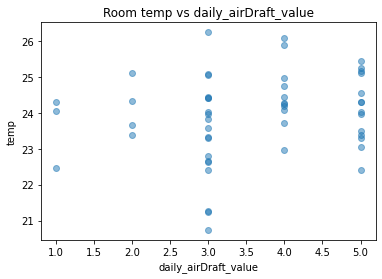

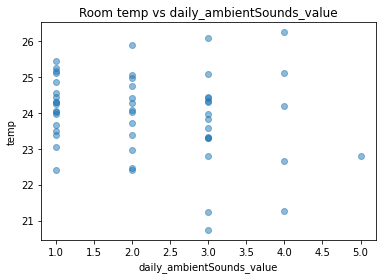

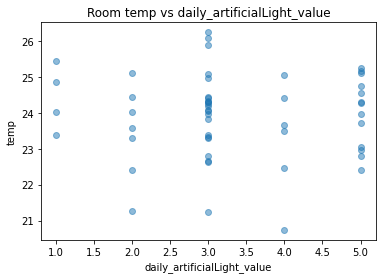

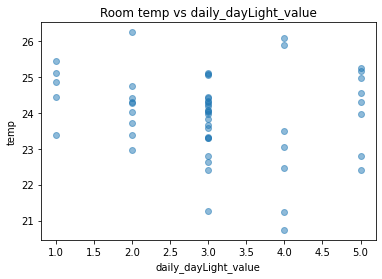

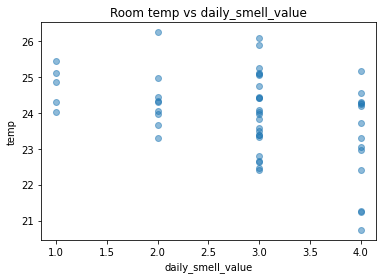

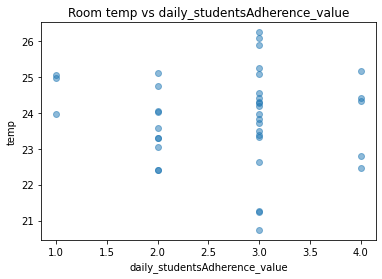

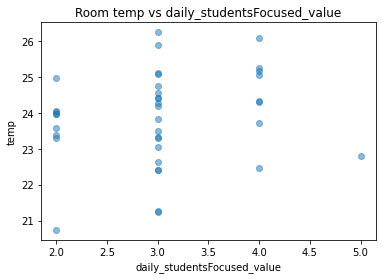

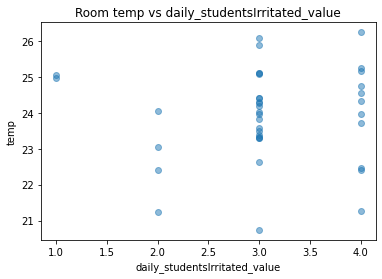

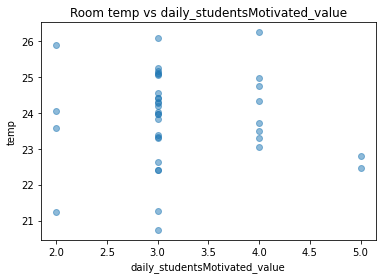

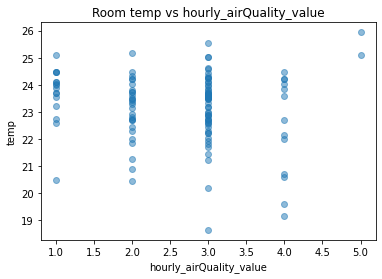

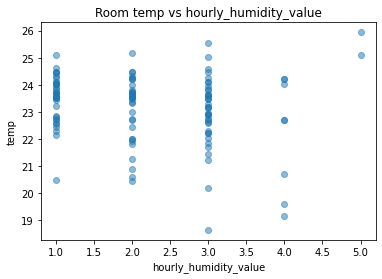

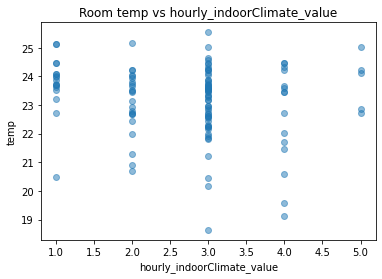

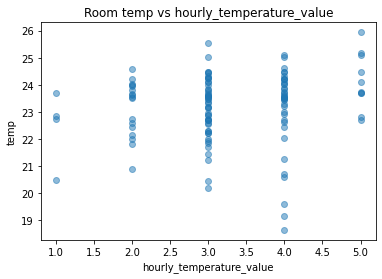

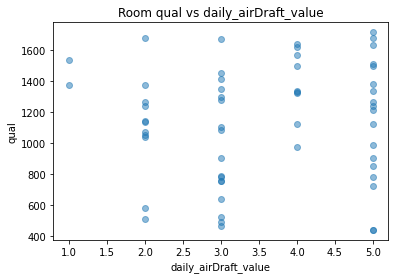

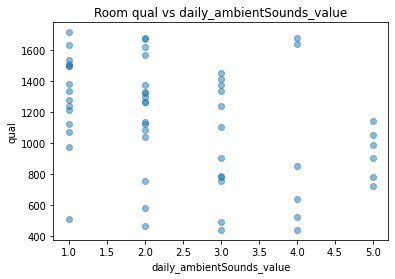

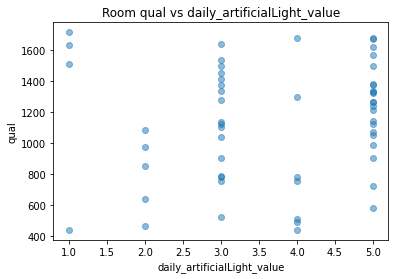

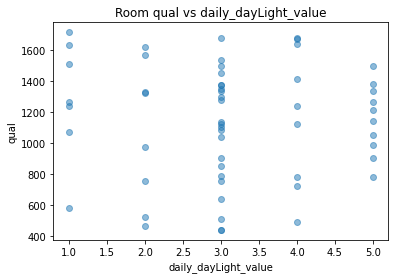

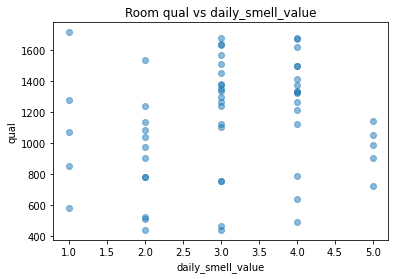

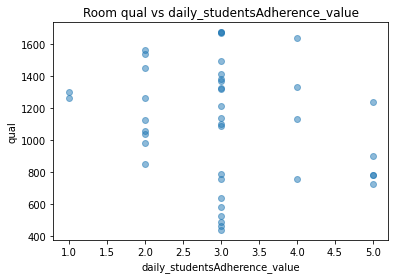

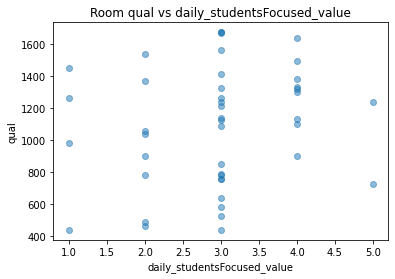

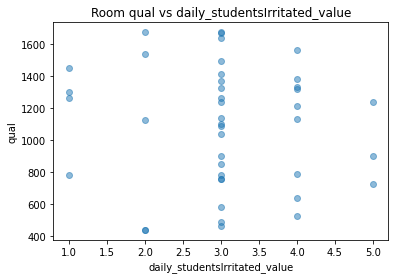

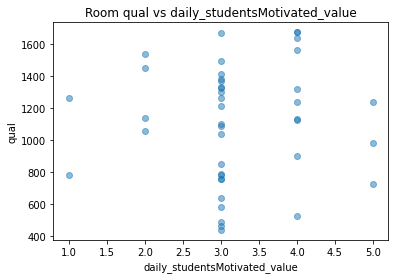

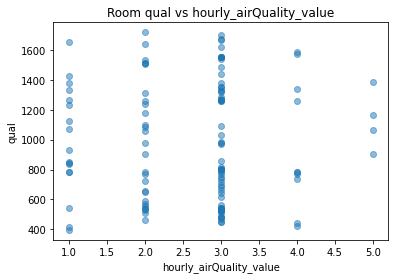

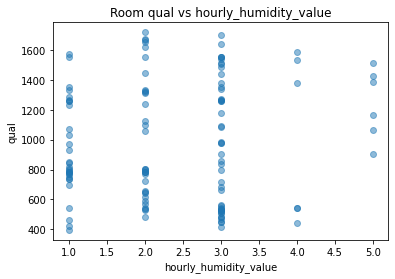

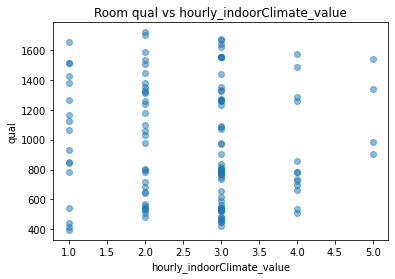

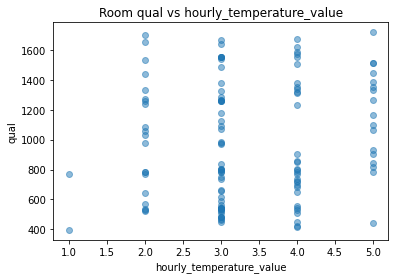

In [12]:
for type in ['temp','qual']:
    
    #for each feedback type
    for dataframe in [daily_airDraft_df,daily_ambientSounds_df,daily_artificialLight_df,daily_dayLight_df,daily_smell_df,daily_studentsAdherence_df,daily_studentsFocused_df,daily_studentsIrritated_df,daily_studentsMotivated_df,hourly_airQuality_df,hourly_humidity_df,hourly_indoorClimate_df,hourly_temperature_df]:
        #print(dataframe.columns)
        x = dataframe[dataframe.columns[1]] #feedback value
        y = []

        for time, room in zip(dataframe[dataframe.columns[0]],dataframe[dataframe.columns[2]]): #0=timestamp, 2=roomName
            #max getting room air temp/qual for that room in the past hour
            y.append(get_max_in_past_hour(time,room,type))
        
        plt.figure()
        plt.scatter(x, y, alpha=0.5)

        plt.title("Room "+type + " vs " + dataframe.columns[1])
        plt.xlabel(dataframe.columns[1])
        plt.ylabel(type)
        
        plt.savefig("../plots/room_air_"+type+"/"+dataframe.columns[1]+".png")
        plt.show()




/home/ben/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


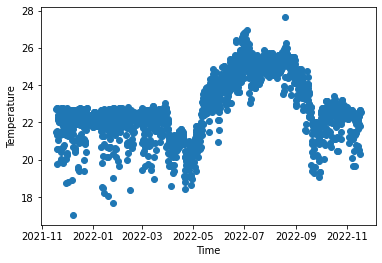

In [13]:
x = r0_16_temp_df['timestamp']
y = r0_16_temp_df['value']

plt.scatter(x,y)
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

In [18]:
r0_16_temp_df.sort_values(by='timestamp')[:50]

,timestamp,value,reduced
0,2021-11-17 17:28:24,21.459999,Reduced
1,2021-11-18 00:13:24,22.740000,Reduced
2,2021-11-18 06:28:24,22.740000,Reduced
3,2021-11-18 07:43:24,19.779999,Reduced
4,2021-11-18 12:58:24,20.600000,Reduced
5,2021-11-18 14:13:24,21.559999,Reduced
6,2021-11-18 17:58:36,21.299999,Reduced
7,2021-11-19 02:28:36,22.799999,Reduced
8,2021-11-19 05:28:36,22.799999,Reduced
9,2021-11-19 07:58:36,21.039999,Reduced


In [15]:
# temperature_values = []
# for time, room in zip(daily_studentsAdherence_df['daily_studentsAdherence_timestamp'],daily_studentsAdherence_df['roomName']):
#     temperature_values.append(get_max_in_past_hour(time,room,'temp'))
    

Report on missing data

In [16]:
# print('Total rows: ',len(temperature_values))
# print("No data: ",temperature_values.count(np.nan))
# #print("No data for past hour: ",temperature_values.count('na'))
# print("We have data for: ",len(temperature_values) - temperature_values.count(np.nan) - temperature_values.count('no data'))